In [1]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
df = pd.read_excel("/content/drive/MyDrive/Hugo's Portfolio/Introducing NBEATSx to Realized Volatility Forecasting (Research)/S&P 500 Realized Volatility (NBEATSx).xlsx",index_col='Date',parse_dates=True)


Mounted at /content/drive


In [3]:
df = pd.read_excel("S&P 500 Realized Volatility (NBEATSx).xlsx",index_col='Date',parse_dates=True)


In [4]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'Realised':'y'}, inplace=True)
train = df.iloc[:int(len(df['y'])*0.7)]
test = df.iloc[int(len(df['y'])*0.7)]
validation_length=int(len(df['y'])*0.7)-int(len(df['y'])*0.6)

Epoch: 150 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: MSE() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005

# H=1 Forecasts

In [5]:
df=df[:len(df["y"])-1]

In [6]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [7]:
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [8]:
df_new=df[int(len(df['y'])*0.7*0.5):]

In [9]:
df_new.shape

(3801, 4)

In [10]:
for i in range(15):
  model = NBEATSx(h=1, input_size=21,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df_new,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 98234803


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 99950616


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 96520212


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 59755178


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 33850135


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 73832475


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 126279033


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 31011721


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 13222189


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 65495659


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 98389108


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 71393022


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 82704971


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 52885403


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 17024572


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [11]:
Accuracy

[63.823777662961724,
 61.39907200410137,
 61.9242313483468,
 63.40149049145054,
 62.101278643920345,
 62.34048047922853,
 63.899671252598445,
 63.30297915563789,
 62.46423385131923,
 62.292319762626704,
 63.505509143648894,
 64.14318596154615,
 63.379309972904196,
 63.07316737070083,
 63.85485704341517]

In [12]:
RMSE

[0.0025383427725608945,
 0.0025715395004933814,
 0.002592658959042147,
 0.0025406981483700906,
 0.002550143606528412,
 0.0025819660779599586,
 0.0025084077936750483,
 0.002539214333619813,
 0.0026085090763358835,
 0.0026107436772048057,
 0.0025357623416050554,
 0.002551732889417127,
 0.0025631677946000046,
 0.0025597624155356447,
 0.0024974572491388495]

In [13]:
Quasilikelihood

[0.09569535830311587,
 0.09327908015595048,
 0.0973601030840315,
 0.09571373587004738,
 0.09476830824043671,
 0.10040331219459994,
 0.09317268695510288,
 0.09343790848290053,
 0.1017234593087783,
 0.10134612911083966,
 0.09383008129130922,
 0.10091218467802365,
 0.09839546679174968,
 0.09943832446665002,
 0.09423735692940774]

Text(0, 0.5, 'S&P 500 Realized Volatility')

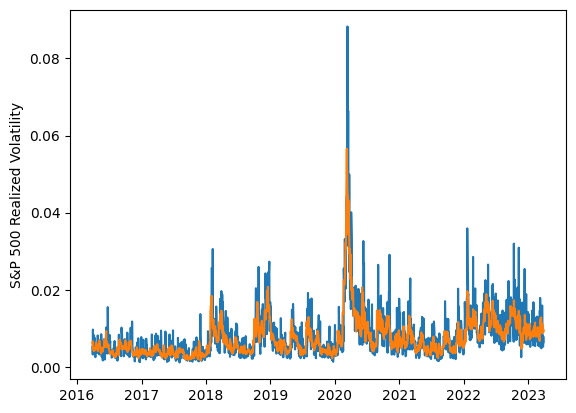

In [14]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")

# H=3 Forecasts

In [17]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [18]:
for i in range(15):
  model = NBEATSx(h=3, input_size=21,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df_new,val_size=9,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=3)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 72212021


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 90059735


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 123237621


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 76904638


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 80604218


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 106944628


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 100466907


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 43207802


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 21328356


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 65770726


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 22191114


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 110111445


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 107390295


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 90877724


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 71464140


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [19]:
RMSE

[0.002564561980963252,
 0.002537391149262571,
 0.002580538941143891,
 0.0025316194185053074,
 0.002578274549628785,
 0.0025837582691033544,
 0.0025393416956079,
 0.002503904850753154,
 0.0025565546100907734,
 0.0025699284981663675,
 0.0025359649738009604,
 0.0025220787384150644,
 0.0025882270655280862,
 0.0024782555422952803,
 0.002599917655925674]

In [20]:
Accuracy


[62.89825764023252,
 63.86073444263549,
 62.5946664412566,
 62.9986903255928,
 62.667760831090135,
 62.966083916489225,
 62.96472501224512,
 63.85716744419192,
 63.14087781477371,
 62.67367735969229,
 63.91830608886742,
 63.41924721377761,
 62.848824258691806,
 64.30348391751674,
 61.86463833783624]

In [21]:
Quasilikelihood

[0.09496754718888593,
 0.09384922624041661,
 0.09589067980759286,
 0.09050364466620803,
 0.09783033587316604,
 0.10140963569309763,
 0.09123661082843491,
 0.08938013746041473,
 0.09523744517406774,
 0.0968212526640251,
 0.09140209546026366,
 0.09063252395533103,
 0.09689319973375235,
 0.08716884685965176,
 0.09458907456285373]

Text(0, 0.5, 'S&P 500 Realized Volatility')

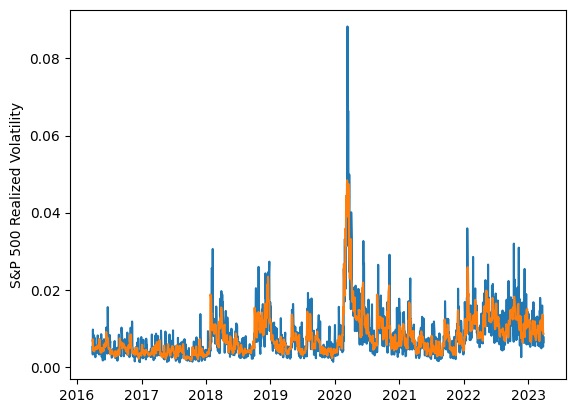

In [22]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")

# H=5 Forecasts

In [23]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [24]:
for i in range(15):
  model = NBEATSx(h=5, input_size=21,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df_new,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 4214688


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 119117420


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 35996225


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 59302546


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 62836079


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 22795841


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 93930252


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 118900141


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 89772967


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42368768


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 3007360


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 113866491


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 114767002


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 44906160


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 47665248


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [25]:
RMSE

[0.0027316132265702326,
 0.0026569725899072277,
 0.002716508319679749,
 0.002776137182057636,
 0.002687447520913858,
 0.0026666545797280395,
 0.002755863895627335,
 0.002685890278612757,
 0.002779727594345305,
 0.002706934505805962,
 0.002755511282370863,
 0.002725160357263829,
 0.002726546045269766,
 0.00273174692430051,
 0.00276097042879129]

In [26]:
Accuracy

[61.74928772632428,
 62.48717702648814,
 61.495674086904884,
 60.29129553569672,
 61.800610615371056,
 62.123360533108674,
 60.82286898595526,
 61.93841096251851,
 59.990209475267655,
 61.53361112404585,
 61.59904557169082,
 61.33857453453623,
 61.185211910546954,
 61.19825540901896,
 60.73862273932677]

In [27]:
Quasilikelihood

[0.10800925917551968,
 0.09639579695209644,
 0.1019127935822838,
 0.10655295581846057,
 0.09844573748529264,
 0.09886771301573342,
 0.10444274636428816,
 0.09942900534561784,
 0.1053605329653682,
 0.0977352120010239,
 0.11061658706074307,
 0.10268367111909624,
 0.10112912141911225,
 0.10102691800706548,
 0.10558446874954462]

Text(0, 0.5, 'S&P 500 Realized Volatility')

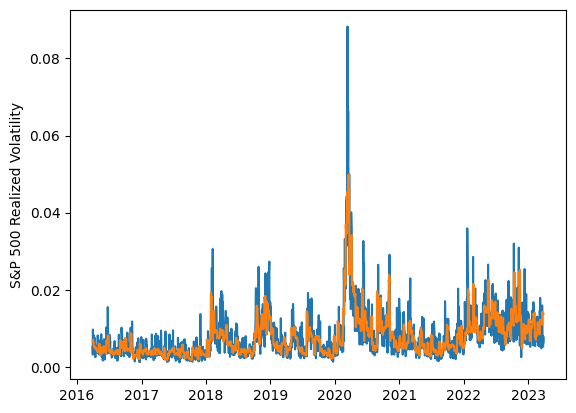

In [28]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")

# H=10 Forecasts

In [43]:
test_length=1750

In [44]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [45]:
for i in range(15):
  model = NBEATSx(h=10, input_size=21,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df_new,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=10)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 61262149


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 84818838


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 102492681


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 26861978


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 16962040


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 115985725


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 82820905


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 91902181


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 26720574


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 12988091


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 61703001


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 2674326


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 64213068


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 118465277


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 76753174


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [46]:
RMSE

[0.0029961089302744347,
 0.0029525766047467294,
 0.002952963022248065,
 0.0030090034829851845,
 0.0029515562065429496,
 0.0029987447450845737,
 0.003005872003931407,
 0.0029637883686977388,
 0.002926791916879538,
 0.0029871892608063573,
 0.0029399280173690616,
 0.0030030266253946074,
 0.002940269410896392,
 0.002962504126155864,
 0.0029607574746083622]

In [47]:
Accuracy

[59.17717932338351,
 59.5405641990733,
 60.31950489058978,
 58.34511492552278,
 59.40052612919586,
 59.08337944711196,
 58.57699557362381,
 59.25644231142331,
 60.37592676826399,
 59.05647439090773,
 59.799859619965815,
 58.69322732626796,
 59.7021192628246,
 59.02436287377157,
 59.571665836746625]

In [48]:
Quasilikelihood

[0.1300369027362121,
 0.12343342312083436,
 0.13050262276477487,
 0.12776438113667885,
 0.12428571665937733,
 0.13043976335406432,
 0.12962519531327057,
 0.1247451222435827,
 0.12391757891552437,
 0.12724807151652798,
 0.12537137930630274,
 0.1268632517563347,
 0.12416395355539672,
 0.11998002487697056,
 0.12736525941621352]

Text(0, 0.5, 'S&P 500 Realized Volatility')

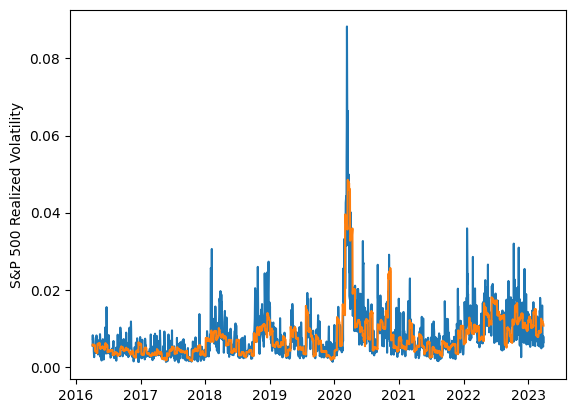

In [49]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")

# H=22 Forecasts

In [50]:
test_length=1738

In [51]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [52]:
for i in range(15):
  model = NBEATSx(h=22, input_size=21,
                  loss=MQLoss(level=[90]),
                  scaler_type='minmax',
                  learning_rate= 0.0001,
                  stack_types=['identity','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=0,
                  hist_exog_list=['VIX'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=df_new,val_size=22,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=22)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 49840064


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 59562948


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 40831858


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 57635110


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 66749545


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 32145582


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 102677917


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 35850809


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 20576547


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 29362670


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 25166357


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 87677231


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 124667430


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 117670407


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 111133165


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [53]:
RMSE

[0.0033847455856988815,
 0.003397062276037357,
 0.003371837646570467,
 0.0034033550981601777,
 0.0033937805450188828,
 0.003379619874190171,
 0.0034407621663371905,
 0.003385471687244581,
 0.0033696689349058365,
 0.0033600858128245564,
 0.0033743862161229243,
 0.003399312290043658,
 0.0033970490638728203,
 0.0033712043277940207,
 0.003365283074476763]

In [54]:
Accuracy

[51.6119747879402,
 51.534379300341996,
 51.85715031401347,
 51.32741082758188,
 51.38614157237691,
 51.39434741825275,
 50.354465350997835,
 51.78819499258848,
 51.575102827360176,
 52.23058626758286,
 51.73258357893123,
 51.20041009241968,
 51.41455601789999,
 51.8612261691952,
 51.838684661394495]

In [55]:
Quasilikelihood

[0.17188006061607952,
 0.17403275923370562,
 0.17137044829145145,
 0.17444654084311229,
 0.17121486738546102,
 0.17101488207573765,
 0.17365322190135044,
 0.1719414175033931,
 0.16938387389423537,
 0.17182574457940253,
 0.17010973377029837,
 0.17242064343802438,
 0.17456749115062017,
 0.17073432700762184,
 0.16956650102137905]

Text(0, 0.5, 'S&P 500 Realized Volatility')

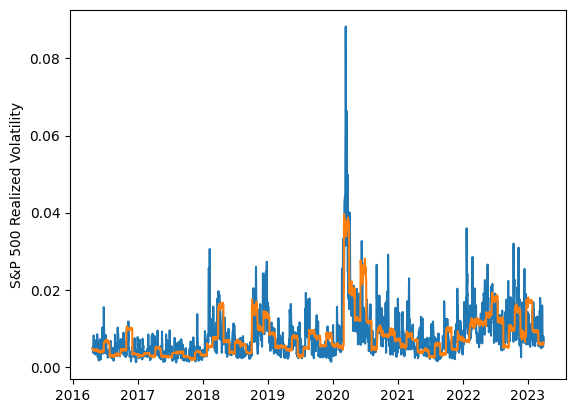

In [56]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")